In [122]:
from tqdm.auto import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

In [123]:
# Read configuration file
config_set = read_config.read_config('./config.ini')
# Define Target
if int(config_set['target_lag'])==20:
    target='DELV120'
if int(config_set['target_lag'])==16:
    target='DELV96'
if int(config_set['target_lag'])==12:
    target='DELV72'
if int(config_set['target_lag'])==8:
    target='DELV48'
if int(config_set['target_lag'])==4:
    target='DELV24'
seeds = np.arange(0,7,1)#np.arange(100,131,1)

In [124]:
target

'DELV24'

In [125]:
var_names =  performance_scores.scores_seeds(seed=0,target=target,lag=int(config_set['target_lag']),exp='shipsplus').read_stored()['var_names']

In [126]:
len(var_names)

28

In [127]:
list(var_names)

['DELV24',
 'T200',
 'T250',
 'LAT',
 'CSST',
 'PSLV',
 'Z850',
 'D200',
 'EPOS',
 'SHDC',
 'RHMD',
 'TWAC',
 'G200',
 'TADV',
 'SHGC',
 'POT',
 'POT2',
 'LHRD',
 'VSHR',
 'PER',
 'VPER',
 'R001',
 'R000',
 'SHMD',
 'PVOR',
 'SHL1',
 'SHL0',
 'pc20']

# With causal

In [128]:
score_causal = []
for seed in tqdm(seeds):
    causal_results = performance_scores.scores_seeds(seed=seed,
                                                     target=target,
                                                     lag=int(config_set['target_lag']),
                                                     exp='shipsplus').run_score_causalFS()
    score_causal.append(causal_results)
    del causal_results
    gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

In [129]:
r2_train_causalFS, r2_valid_causalFS, r2_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    r2_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2']) for j in range(len(score_causal[i]))])
    r2_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2']) for j in range(len(score_causal[i]))])
    r2_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])

## Find variable lists

In [130]:
def find_best_var_per_seed_causal(r2,score_causal):
    causal_varlists = []
    for i in range(len(score_causal)):
        causal_varlists.append(score_causal[i][np.asarray(r2[i]).argmax()]['corrrank'])
    return causal_varlists

def find_best_var_per_seed_corrXAI(r2,score_corr):
    corr_varlists = []
    for i in range(len(score_corr)):
        corr_varlists.append(score_correlation[i]['corrrank'].sort_values(ascending=False).index[0:np.asarray(r2[i]).argmax()+1])
    return corr_varlists

def find_best_var_per_seed_XAI(r2,score_corr):
    corr_varlists = []
    for i in range(len(score_corr)):
        corr_varlists.append(score_corr[i]['XAIrank'].sort_values(ascending=False).index[0:np.asarray(r2[i]).argmax()+1])
    return corr_varlists

def count_all_varlists(varlists):
    from collections import Counter
    from functools import reduce
    freq = list(map(Counter, varlists)) 
    res = {ele: [cnt[ele] for cnt in freq] for ele in {ele for cnt in freq for ele in cnt}}
    
    dict1 = res
    for k, v in dict1.items():
        dict1[k] = reduce(lambda a, b: a+b, v)
    return pd.Series((dict1))

In [131]:
causal_varlists = find_best_var_per_seed_causal(r2_valid_causalFS,score_causal)
count_causallists = count_all_varlists(causal_varlists)

In [132]:
bestvars=count_causallists.sort_values(ascending=False)[:40] 

In [133]:
count_causallists.sort_values(ascending=False)[:50] 

T200    7
POT     7
PSLV    7
G200    6
SHMD    6
SHL1    4
Z850    3
pc20    3
PVOR    3
SHL0    2
POT2    2
R000    2
TADV    1
LAT     1
dtype: int64

In [134]:
import os
save_dir= '/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/ships_plus_new/results/4/XAI_shipsplus/'
# List to store the loaded results
score_corr = []

# Load each pickle file and append to score_corr
for seed in seeds:
    file_path = os.path.join(save_dir, f'xai_results_fold_{seed}.pkl')
    with open(file_path, 'rb') as f:
        corr_results = pickle.load(f)
        score_corr.append(corr_results)

In [135]:
r2_train_XAIFS, r2_valid_XAIFS, r2_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_XAIFS.append(trains)
    r2_valid_XAIFS.append(valids)
    r2_test_XAIFS.append(tests)

In [136]:
xai_varlists = find_best_var_per_seed_XAI(r2_valid_XAIFS,score_corr)
count_xailists = count_all_varlists(xai_varlists)

In [137]:
count_xailists.sort_values(ascending=False)[:40] #4

POT     7
VSHR    7
PSLV    7
LAT     5
CSST    4
T200    3
TWAC    3
PVOR    3
SHL0    2
POT2    2
pc20    2
SHGC    1
G200    1
dtype: int64

## With Correlation

In [138]:
score_correlation = []
for seed in tqdm(seeds):
    correlation_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='shipsplus').run_score_corrFS(shapez=np.asarray(miss.flatten(shapez_causalFS)).max())
    score_correlation.append(correlation_results)
    del correlation_results
    gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

In [139]:
r2_train_corrFS, r2_valid_corrFS, r2_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_corrFS.append(trains)
    r2_valid_corrFS.append(valids)
    r2_test_corrFS.append(tests)

In [140]:
corr_varlists = find_best_var_per_seed_corrXAI(r2_valid_corrFS,score_correlation)
count_corrlists = count_all_varlists(corr_varlists)

In [141]:
count_corrlists.sort_values(ascending=False)[:50] #4

POT     7
TWAC    6
G200    5
VSHR    5
T200    4
pc20    4
LAT     4
TADV    3
PVOR    2
PSLV    2
SHL1    1
SHL0    1
SHMD    1
dtype: int64

In [75]:
count_corrlists.sort_values(ascending=False)[:50] #8

POT     7
pc20    5
R001    5
TWAC    5
VPER    4
G200    4
PER     4
EPOS    4
VSHR    4
T200    4
R000    4
SHGC    2
LAT     2
CSST    1
SHDC    1
dtype: int64

In [103]:
count_corrlists.sort_values(ascending=False)[:50] #12

MSLP    7
POT     5
SHGC    4
EPOS    3
pc20    3
R001    2
CSST    1
SHMD    1
G200    1
SHDC    1
POT2    1
dtype: int64

In [19]:
count_corrlists.sort_values(ascending=False)[:50] #16

MSLP    7
POT     5
SHGC    3
pc20    3
EPOS    2
SHMD    1
SHDC    1
dtype: int64

In [44]:
count_corrlists.sort_values(ascending=False)[:50] #20

POT     7
MSLP    6
EPOS    4
pc20    4
D200    2
VPER    1
LAT     1
PVOR    1
SHDC    1
dtype: int64

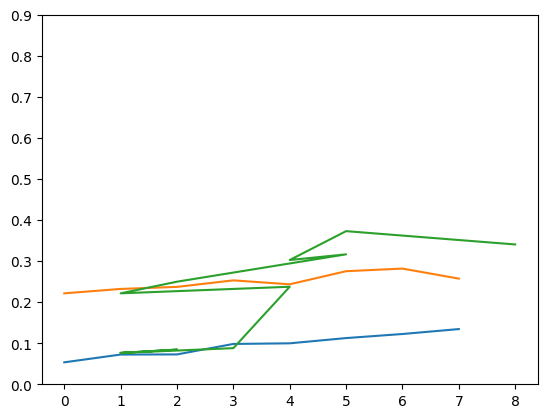

In [31]:
i=3
plt.plot(r2_train_corrFS[i])
plt.plot(r2_valid_corrFS[i])
plt.plot(shapez_causalFS[i],r2_valid_causalFS[i])
plt.ylim(0,0.9)
plt.show()

In [20]:
import os
save_dir= '/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/ships_plus_new/results/16/XAI_shipsplus/'
# List to store the loaded results
score_corr = []

# Load each pickle file and append to score_corr
for seed in seeds:
    file_path = os.path.join(save_dir, f'xai_results_fold_{seed}.pkl')
    with open(file_path, 'rb') as f:
        corr_results = pickle.load(f)
        score_corr.append(corr_results)

In [21]:
r2_train_XAIFS, r2_valid_XAIFS, r2_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_XAIFS.append(trains)
    r2_valid_XAIFS.append(valids)
    r2_test_XAIFS.append(tests)

In [22]:
xai_varlists = find_best_var_per_seed_XAI(r2_valid_XAIFS,score_corr)
count_xailists = count_all_varlists(xai_varlists)

In [23]:
count_xailists.sort_values(ascending=False)[:40] #4

G200    6
POT     5
SHGC    3
LAT     3
SHMD    2
CSST    2
T250    2
MSLP    1
T200    1
SHL0    1
SHDC    1
dtype: int64

In [79]:
count_xailists.sort_values(ascending=False)[:40] #8

POT     7
EPOS    6
VPER    5
pc20    5
T250    4
SHGC    4
Z850    3
PVOR    3
T200    3
CSST    1
SHL0    1
TWAC    1
POT2    1
LAT     1
dtype: int64

In [24]:
count_xailists.sort_values(ascending=False)[:40] #12

G200    6
POT     5
SHGC    3
LAT     3
SHMD    2
CSST    2
T250    2
MSLP    1
T200    1
SHL0    1
SHDC    1
dtype: int64